In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json

## Data

In [3]:
PATH = Path('data/carvana')
MASKS_FN = 'train_masks.csv'
META_FN = 'metadata.csv'
masks_csv = pd.read_csv(PATH/MASKS_FN)
meta_csv = pd.read_csv(PATH/META_FN)

In [4]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [5]:
TRAIN_DN = 'train-128'
MASKS_DN = 'train_masks-128'
sz = 128
bs = 64
nw = 16

In [6]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return open_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 0

In [7]:
x_names = np.array([Path(TRAIN_DN)/o for o in masks_csv['img']])
y_names = np.array([Path(MASKS_DN)/f'{o[:-4]}_mask.png' for o in masks_csv['img']])

In [8]:
val_idxs = list(range(1008))
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)

In [9]:
aug_tfms = [RandomRotate(4, tfm_y=TfmType.PIXEL),
            RandomFlip(tfm_y=TfmType.PIXEL),
            RandomLighting(0.05, 0.05)]

In [10]:
tfms = tfms_from_model(vgg16, sz, crop_type=CropType.NO, tfm_y=TfmType.NO, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
denorm = md.trn_ds.denorm

## Simple upsample

In [11]:
f = vgg16
cut,lr_cut = model_meta[f]

In [12]:
def get_base():
    layers = cut_model(f(True), cut)
    return nn.Sequential(*layers)

In [13]:
def mask_loss(pred,targ):
    return F.binary_cross_entropy_with_logits(pred[:,0],targ[:,0])

def mask_acc(pred,targ): return accuracy_multi(pred[:,0], targ[:,0], 0.5)

In [14]:
def dice(pred, targs):
    m1 = (pred[:,0]>0).float()
    m2 = targs[:,0]
    return 2. * (m1*m2).sum() / (m1+m2).sum()

In [15]:
class StdUpsample(nn.Module):
    def __init__(self, nin, nout):
        super().__init__()
        self.conv = nn.ConvTranspose2d(nin, nout, 2, stride=2)
        self.bn = nn.BatchNorm2d(nout)
        
    def forward(self, x): return self.bn(F.relu(self.conv(x)))

In [16]:
class Upsample16(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.up1 = StdUpsample(512,256)
        self.up2 = StdUpsample(256,256)
        self.up3 = StdUpsample(256,256)
        self.up4 = StdUpsample(256,256)
        self.up5 = nn.ConvTranspose2d(256, 1, 2, stride=2)
        
    def forward(self,x):
        x = F.relu(self.rn(x))
        x = self.up1(x)
        x = self.up2(x)
        x = self.up3(x)
        x = self.up4(x)
        x = self.up5(x)
        return x

In [17]:
m_base = get_base()

In [17]:
class UpsampleModel():
    def __init__(self,model,name='upsample'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model)[1:]]

In [19]:
m = to_gpu(Upsample16(m_base))
models = UpsampleModel(m)

In [20]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=mask_loss
learn.metrics=[mask_acc,dice]

In [21]:
learn.freeze_to(1)

In [22]:
x,y = next(iter(md.trn_dl))

In [23]:
y.shape

torch.Size([64, 3, 128, 128])

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 86%|████████▌ | 55/64 [00:15<00:02,  3.60it/s, loss=1.74] 

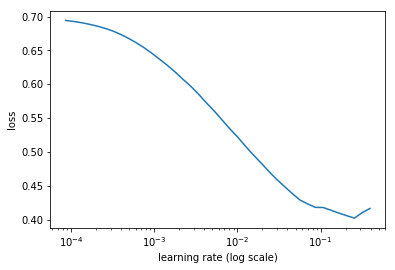

In [24]:
learn.lr_find()
learn.sched.plot()

In [18]:
lr=1e-2

In [27]:
learn.fit(lr,1,cycle_len=4,use_clr=(20,8))

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

 45%|████▌     | 29/64 [00:09<00:11,  3.18it/s, loss=0.178]

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   mask_acc   dice           
    0      0.130168   0.101706   0.956718   0.897401  
    1      0.096448   0.086279   0.959714   0.907395        
    2      0.082896   0.08107    0.963913   0.915247        
    3      0.074638   0.077358   0.964315   0.918381        



[0.07735815, 0.9643154144287109, 0.9183809957247494]

In [28]:
learn.save('tmp')

In [56]:
learn.load('tmp')

In [57]:
learn.unfreeze()
learn.bn_freeze(True)
lrs = np.array([lr/100,lr/10,lr])/2

In [58]:
learn.fit(lrs,1,cycle_len=4,use_clr=(20,8))

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss   mask_acc   dice           
    0      0.202468   0.05276    0.978614   0.949546  
    1      0.071524   0.029284   0.987943   0.971754        
    2      0.037767   0.02497    0.989956   0.976049        
    3      0.027516   0.0236     0.99026    0.977326        



[0.023600407, 0.9902599044144154, 0.9773264647986332]

In [34]:
learn.save('128uvn')

## U-net (ish)

In [19]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = output
    def remove(self): self.hook.remove()

In [20]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p))

In [21]:
m_base = get_base()

In [22]:
m_base

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True

In [23]:
class Unet16(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[0][i]) for i in [5,12,22,32,42]]
        self.up0 = UnetBlock(512,512,256)
        self.up1 = UnetBlock(256,512,256)
        self.up2 = UnetBlock(256,256,256)
        self.up3 = UnetBlock(256,128,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5  = nn.Conv2d(256,  1,  1)
        
        
    def forward(self,x):
        x = F.relu(self.rn(x))
        x = self.up0(x, self.sfs[4].features)
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x)
        return x

In [24]:
m = to_gpu(Unet16(m_base))

In [25]:
models = UpsampleModel(m)

In [26]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=mask_loss
learn.metrics=[mask_acc,dice]

In [27]:
learn.freeze_to(1)

In [60]:
learn.lr_find()
learn.sched.plot()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

  6%|▋         | 4/64 [00:03<00:58,  1.02it/s, loss=0.25] 


KeyboardInterrupt: 

In [ ]:
learn.fit(lr,1,cycle_len=8,use_clr=(20,8))

In [46]:
[o.features.size() for o in m.sfs]

[torch.Size([48, 64, 128, 128]),
 torch.Size([48, 128, 64, 64]),
 torch.Size([48, 256, 32, 32]),
 torch.Size([48, 512, 16, 16]),
 torch.Size([48, 512, 8, 8])]

In [47]:
learn.save('128uvn-tmp')

In [61]:
learn.load('128uvn-tmp')

In [28]:
learn.unfreeze()
learn.bn_freeze(True)
lrs = np.array([lr/100,lr/10,lr])

In [63]:
learn.fit(lrs,1,cycle_len=40,use_clr=(20,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=40), HTML(value='')))

epoch      trn_loss   val_loss   mask_acc   dice            
    0      0.014506   0.015013   0.994182   0.9863    
    1      0.014159   0.014045   0.994158   0.986932        
    2      0.013604   0.013731   0.994149   0.987211        
    3      0.013275   0.013813   0.994781   0.987287        
    4      0.012779   0.01275    0.99504    0.988282        
    5      0.012201   0.013076   0.995215   0.988199        
    6      0.011732   0.012289   0.995219   0.988947        
    7      0.011283   0.012439   0.995423   0.988988        
    8      0.011008   0.012216   0.995493   0.989108        
    9      0.010794   0.01222    0.995527   0.989281        
    10     0.010542   0.011736   0.995445   0.989526        
    11     0.01033    0.011766   0.995556   0.98957         
    12     0.0101     0.011725   0.995586   0.989713        
    13     0.009877   0.011697   0.995693   0.989795         
    14     0.009738   0.01185    0.99573    0.98987          
    15     0.009589   0.0116

[0.013684367, 0.9958349876105785, 0.9901689795922313]

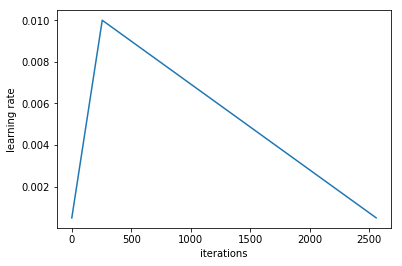

In [64]:
learn.sched.plot_lr()

In [65]:
learn.save('128uvn-0')

In [ ]:
learn.load('128uvn-0')

In [66]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

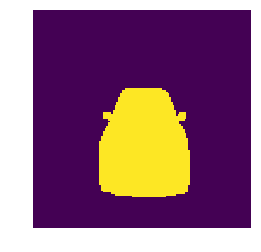

In [67]:
# ax = show_img(denorm(x)[0])
show_img(py[0][0]>0);

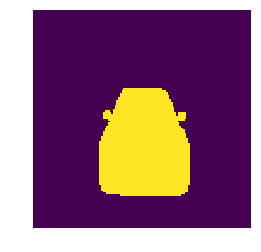

In [70]:
# ax = show_img(denorm(x)[0])
show_img(denorm(y)[0,...,-1]);

## 512x512

In [30]:
sz=512
bs=16

In [31]:
tfms = tfms_from_model(vgg16, sz, crop_type=CropType.NO, tfm_y=TfmType.PIXEL, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=4, classes=None)
denorm = md.trn_ds.denorm

In [33]:
m_base = get_base()
m = to_gpu(Unet16(m_base))
models = UpsampleModel(m)

In [34]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=mask_loss
learn.metrics=[mask_acc,dice]

learn.freeze_to(1)

In [38]:
import objgraph
objgraph.show_most_common_types(limit=50)


function                   41702
dict                       21600
list                       21316
tuple                      20385
PosixPath                  10178
weakref                    9068
method_descriptor          8985
cell                       7242
getset_descriptor          5516
builtin_function_or_method 5265
Argument                   4930
type                       4835
set                        4052
wrapper_descriptor         3499
property                   2187
module                     2084
ModuleSpec                 2071
SourceFileLoader           1820
WeakSet                    1352
staticmethod               1347
method                     1178
Parameter                  1046
OrderedDict                1036
member_descriptor          703
classmethod                683
Function                   556
MovedAttribute             487
vectorize                  443
ABCMeta                    427
itemgetter                 426
cython_function_or_method  328
frozenset  

In [39]:
learn.load('128uvn-0')

In [40]:
learn.fit(lr,1,cycle_len=5,use_clr=(20,5))

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

  0%|          | 0/255 [00:00<?, ?it/s]


RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1518244421288/work/torch/lib/THC/generic/THCStorage.cu:58

In [ ]:
learn.save('512uvn-tmp')

In [ ]:
learn.unfreeze()
learn.bn_freeze(True)

In [ ]:
learn.fit(lrs,1,cycle_len=8,use_clr=(20,8))

In [ ]:
learn.save('512uvn')

In [ ]:
learn.load('512uvn')

In [ ]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

In [ ]:
show_img(py[0][0]>0);

In [ ]:
show_img(y[0,...,-1]);

## 1024x1024

In [ ]:
sz=1024
bs=4

In [ ]:
tfms = tfms_from_model(vgg16, sz, crop_type=CropType.NO, tfm_y=TfmType.PIXEL, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=4, classes=None)
denorm = md.trn_ds.denorm

In [ ]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UpsampleModel(m)

In [ ]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=mask_loss
learn.metrics=[mask_acc,dice]

learn.freeze_to(1)

In [ ]:
learn.load('512uvn')

In [ ]:
learn.fit(lr,1,cycle_len=2,use_clr=(20,4))

In [ ]:
learn.save('1024uvn-tmp')

In [ ]:
learn.unfreeze()
learn.bn_freeze(True)

In [ ]:
learn.fit(lrs/2,1,cycle_len=4,use_clr=(20,8))

In [ ]:
learn.save('1024uvn')

In [ ]:
learn.load('1024uvn')

In [ ]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

In [ ]:
show_img(py[0][0]>0);

In [ ]:
show_img(y[0,...,-1]);